<a href="https://colab.research.google.com/github/BYakovAisin/QSVM-NLP-Classifier/blob/main/cmsc_457_NLP_QSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [ ]:
left = pd.read_excel('/content/drive/My Drive/msml 602/left.xlsx')
right = pd.read_excel('/content/drive/My Drive/msml 602/right.xlsx')

In [ ]:
#using stopwords method to denoise the data

nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
left['titles']=left['titles'].apply(denoise_text)
right['titles']=right['titles'].apply(denoise_text)

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus_left = get_corpus(left['titles'])
corpus_right = get_corpus(right['titles'])

In [ ]:
from collections import Counter

counter_left = Counter(corpus_left)
counter_right = Counter(corpus_right)


In [ ]:
left['bias'] = 'left' # adding a column indicating the bias of the articles

left

,titles,sources,bias
0,Gretchen Whitmer Rebukes Trump Powerful Essay:...,HuffPost,left
1,Ted Cruz Trump's Hunter Biden Obsession: Move ...,HuffPost,left
2,Trump Faces COVID-19 Surge Critical Midwest Ba...,HuffPost,left
3,Trump Plans Battleground Blitz Despite Growing...,HuffPost,left
4,Trump Campaign Takes Biden's Pope Francis Quot...,HuffPost,left
...,...,...,...
76,Trump's Hunt Red October,Palmer Report,left
77,Despicable Trump Legacy,Palmer Report,left
78,Donald Trump Whole New Twitter Problem,Palmer Report,left
79,Donald Trump Crashing Burning,Palmer Report,left


In [ ]:
right['bias'] = 'right' # adding a column indicating the bias of the articles

right

,titles,sources,bias
0,Kamala Harris Bursts Laughing Asked Socialist ...,FOX News,right
1,Russia's Putin Appears Defend Hunter Biden Bus...,FOX News,right
2,"Gerard Baker: Biden, Dems Win, America's Free ...",FOX News,right
3,Bloomberg Super PAC Outspending Trump Ohio Ahe...,FOX News,right
4,Trump Says Biden Would 'Tie Hands Every Police...,FOX News,right
...,...,...,...
77,Hemingway Harsanyi: Trump's Record Enough Win ...,The Federalist,right
78,"Like Many Conservatives, New York Post Come Ar...",The Federalist,right
79,New York Times Poll: Trump Expands Lead Texas,The Federalist,right
80,7 Leftist Threats Political Terror Coming Whet...,The Federalist,right


In [ ]:
df = pd.concat([left,right],axis=0) #stacking the two dataframes toghether

df

,titles,sources,bias
0,Gretchen Whitmer Rebukes Trump Powerful Essay:...,HuffPost,left
1,Ted Cruz Trump's Hunter Biden Obsession: Move ...,HuffPost,left
2,Trump Faces COVID-19 Surge Critical Midwest Ba...,HuffPost,left
3,Trump Plans Battleground Blitz Despite Growing...,HuffPost,left
4,Trump Campaign Takes Biden's Pope Francis Quot...,HuffPost,left
...,...,...,...
77,Hemingway Harsanyi: Trump's Record Enough Win ...,The Federalist,right
78,"Like Many Conservatives, New York Post Come Ar...",The Federalist,right
79,New York Times Poll: Trump Expands Lead Texas,The Federalist,right
80,7 Leftist Threats Political Terror Coming Whet...,The Federalist,right


In [ ]:
#setting up the X and Y values
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
features = ["phrase #1","phrase #2","phrase #3","phrase #4","phrase #5"]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv_title = CountVectorizer(ngram_range=(1,3),max_features=8)
mat_title = cv_title.fit_transform(X[:,0]).todense()
mat_title = np.array(mat_title)

In [ ]:
training_input = {}
training_input['left'] = mat_title[0:10]
training_input['right'] = mat_title[len(left)+2:len(left)+11]

test_input = {}
test_input['left'] = mat_title[10:15]
test_input['right'] = mat_title[len(left)+11:len(left)+16]

In [ ]:
datapoint = np.vstack((mat_title[15:25],mat_title[len(left)+16:len(left)+26]))
datapoint_y = np.hstack((y[15:25],y[len(left)+16:len(left)+26]))

for i in range(0,len(datapoint_y)):
  if datapoint_y[i] == 'left':
    datapoint_y[i] = 0
  else:
    datapoint_y[i] = 1

In [ ]:
pip install qiskit==0.24.1

In [ ]:
pip install qiskit-terra==0.16.4

In [ ]:
pip install qiskit-aer==0.7.6

In [ ]:
pip install qiskit-ignis==0.5.2

In [ ]:
pip install qiskit-aqua==0.8.2

In [ ]:
pip install qiskit-ibmq-provider==0.12.2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=8, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoint)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  predicted_labels = binarized_predictions.astype(int)
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  predicted_labels = binarized_predictions.astype(int)


In [ ]:
print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoint_y, qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoint_y)/len(predicted_labels)}%')

Testing success ratio: 0.7

Prediction from datapoints set:
  ground truth: ['left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right']
  prediction:   ['left', 'right', 'left', 'left', 'left', 'left', 'right', 'right', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'left', 'right', 'left', 'right', 'left']
  success rate: 65.0%


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


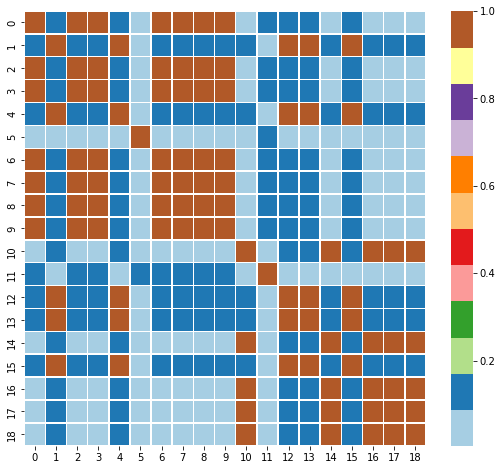

In [ ]:
kernel_matrix = result['kernel_matrix_training']

plt.figure(figsize=(9,8))
sns.heatmap(np.float128(kernel_matrix),cmap='Paired',linewidths=.5)

In [ ]:
kernel_matrix.dtype

dtype('complex128')

In [ ]:
result

{'kernel_matrix_testing': array([[0.16113281, 0.02734375, 0.16113281, 0.16113281, 0.02734375,
         0.11132812, 0.16113281, 0.16113281, 0.16113281, 0.16113281,
         0.16113281, 0.02246094, 0.02734375, 0.02734375, 0.16113281,
         0.02734375, 0.16113281, 0.16113281, 0.16113281],
        [1.        , 0.16113281, 1.        , 1.        , 0.16113281,
         0.02246094, 1.        , 1.        , 1.        , 1.        ,
         0.02734375, 0.11132812, 0.16113281, 0.16113281, 0.02734375,
         0.16113281, 0.02734375, 0.02734375, 0.02734375],
        [1.        , 0.16113281, 1.        , 1.        , 0.16113281,
         0.02246094, 1.        , 1.        , 1.        , 1.        ,
         0.02734375, 0.11132812, 0.16113281, 0.16113281, 0.02734375,
         0.16113281, 0.02734375, 0.02734375, 0.02734375],
        [0.00488281, 0.02246094, 0.00488281, 0.00488281, 0.02246094,
         0.00390625, 0.00488281, 0.00488281, 0.00488281, 0.00488281,
         0.04980469, 0.00195312, 0.0224609